In [2]:
import os
import sys
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


# Get the current working directory
script_dir = Path.cwd()

# Navigate to the parent directory using "../"
input_dir = script_dir / "../input/freshCSVs/"
input_dir = input_dir.resolve()  # Resolve the path to an absolute path

print(f"Current directory: {script_dir}")
print(f"Parent directory: {input_dir}")

Current directory: c:\Users\neora\OneDrive\Documentos\GitHub\operations-moinhos\script
Parent directory: C:\Users\neora\OneDrive\Documentos\GitHub\operations-moinhos\input\freshCSVs


*Indicadores:*

A-Tempo médio entre a decisão e o início do tratamento

B-Tempo médio entre diagnóstico e início do tratamento

C-Tempo médio entre o resultado da biópsia e a infusão do PDL1

D-Percentual de idas à emergência evitadas

E-Taxa de satisfação dos pacientes inseridos no programa de navegação

F-Taxa de evasão de pacientes inseridos no programa de navegação

G-Percentual de pacientes engajados em relação às estratégias de navegação (excluindo os que tiverem as tags abaixo):
Não aderem ao tratamento proposto (tag = Não adesão tto);
Não aderem às orientações (tag = Não adesão estratégias Navegação);


TODOs:

* Botar coisa de mean no datecomparison()
* Códigos para plotar as coisas
* Verificar resultados


***Fixes timeline:***

1. ~~Figure out how to properly graph stuff~~
2. Implement past values integration
3. Implement this in BI

In [15]:
# Reads Json data
def read_json(json_dir):
    """"
    reads all json in a given directory and store them in a dataframe list
    """
    json_filenames = [file.name for file in json_dir.glob('*.json')]

    dataframes = []

    # Reading all JSON files and storing them in 'dataframes'
    for json_filename in json_filenames:

        file_path = json_dir / json_filename
        file_path = file_path.resolve()  # Getting all the list's jsons' paths
        
        print(f"read_json(): Reading json data in {json_filename}")


        if file_path.exists():
            with open(file_path, 'r') as file:
                data = json.load(file)
            try:
                if 'content' in data:
                    df = pd.json_normalize(data['content'])
                else:
                    df = pd.json_normalize(data)
                dataframes.append(df)
            except ValueError as e:
                print(f"read_json_data(): Failed to convert JSON into DataFrame: {e}")
        else:
            print(f"read_json_data(): File {file_path} not found.")

    # Why do we concat all dataframes together?
    if dataframes:
        return dataframes
    
    else:
        print("read_json_data(): No valid json files found.")
        return None

In [16]:
def searchPatientTag(patientsJson, search_tags):
    """
    Given a patientsJson from patients.json, searches for patients with tags in the given list or string
    """

    if type(search_tags) == str:
        has_search_tag = patientsJson["tags"].apply(
        lambda tags: any(tag.get("content") == search_tags for tag in tags)
        )

    if type(search_tags) == list:
        has_search_tag = patientsJson["tags"].apply(
        lambda tags: any(tag.get("content") in search_tags for tag in tags)
        )

    return has_search_tag

In [17]:
def percentage_trues(series, precision):
    """
    Given a boolean series, return their percentage, along with other values to make better graphs
    """
    total_events = len(series)
    total_target_events = sum(series)
    percentage = round(total_target_events / total_events * 100, precision)
    return (total_target_events, total_events,  str(percentage) + " %")

In [18]:
# Reading and storing the relevant JSONs
input_jsonFolder = read_json(input_dir)
eventsJson = input_jsonFolder[0]
informacoes_15Json = input_jsonFolder[1]
patientsJson = input_jsonFolder[2]

read_json_data(): No valid json files found.


TypeError: 'NoneType' object is not subscriptable

In [474]:
# Columns assumed for items A,B and C

inicioTratamento = "formData.inicio"
decisaoTratamento = "formData.decisao"
diagnosticoBiopsia = "formData.liberacao"
resultadoBiopsia = "formData.testemolecular"
infusaoPDL = "formData.infusao"

Client wants us to make A, B and C items for pre and post KPI patients. So we'll have two dataframes, one for each.

Let's start removing the pre-KPI patients from our jsons.

There are more patients in the `patients.json` than in `informacoes_15.json`, which leads to our 2 dataframes having patients that are not in `informacoes_15`.

The chosen approach is to remove the patients in `informacoes_15` that are in the pre-KPI list, making 2 dataframes:

* Pre KPI Dataframe: Patients in `informacoes_15.json` whose ID is in this list
* Post KPI Dataframe: All remaining patients in `informacoes_15.json` (everyone whose ID is not in this list)

Essentially, we are assuming ***all*** Pre-KPI patients will be tagged as such, as this approach includes in the post KPI Dataframes patients who are not in the pre-kpi list, but that doesn't necessarily mean that they are post-KPI.
* We could also go for the 100% solution of Post KPI Dataframe = Patients whose id is in `patients_post_kpi_id`, but this would remove a lot of patients.

For the rest of the notebook, the full list of patients was used (pre and post kpi). Maybe this needs to be changed?

In [475]:
# Getting all patient's IDs who have the "Pré KPI's tag"
is_pre_KPI = searchPatientTag(patientsJson, "Pré KPI's")
patientsJson["is_pre_KPI"] = is_pre_KPI



# Getting the 2 dataframes with all id's we'll be considering for the entire notebook.
patients_pre_kpi_id = patientsJson[patientsJson["is_pre_KPI"]]["id"]
patients_post_kpi_id = patientsJson[patientsJson["is_pre_KPI"] == False]["id"]


# Separating KPIs on informacoes_15json
informacoes_15Json_preKPI = informacoes_15Json[informacoes_15Json['patient.id'].isin(patients_pre_kpi_id)].copy().reset_index()
informacoes_15Json_postKPI = informacoes_15Json[~informacoes_15Json["patient.id"].isin(patients_pre_kpi_id)].copy().reset_index()

# Removing preKPI from events.json
eventsJson_postKPI = eventsJson[eventsJson["patient.id"].isin(patients_post_kpi_id)]

# Removing preKPI from patients.json
patientsJson_postKPI = patientsJson[patientsJson["id"].isin(patients_post_kpi_id)]

Now, let's make sure our data isn't being blurred by some patient with erroneus data.


In [476]:
def timedelta_to_floatDays(timedelta):
    if type(timedelta) == list:
        rounded_days_list = []
        for timedelta_object in timedelta:
            rounded_timedelta = round(timedelta_object.days + (timedelta_object.seconds/3600)/24, 1)
            rounded_days_list.append(rounded_timedelta)
        return rounded_days_list
    
    else:
        rounded_days = round(timedelta.days + (timedelta.seconds/3600)/24, 1)
        return rounded_days
    

In [477]:
import numpy as np

def dateComparison(dataframe, column1, column2):
    
    """
    column1 - column2, returns the mean in a float and all the outliers' rows in a list
    """

    # Initial calculation, to get the mean
    unfiltered_result = (pd.to_datetime(dataframe[column1]) - pd.to_datetime(dataframe[column2]))
    
    unfiltered_median = np.median((unfiltered_result).dropna().dt.days)
    print(unfiltered_median)
    outliers = []

    # Removing outliers, storing their entire dataframe row on outliers list
    index = 0
    for value in unfiltered_result.dt.days:
        if value >= unfiltered_median * 7 or value < 0:
            erroneous_patient_id = dataframe.iloc[index]["patient.fullName"]
            print(f"dateComparison(): Filtering id {erroneous_patient_id} from the ({column1} - {column2}) comparison for erroneous value ({value}).")
            outliers.append(dataframe.iloc[index])
            dataframe = dataframe.drop([index])
        index += 1

    # Recalculating it, now filtered
    filtered_result = (pd.to_datetime(dataframe[column1]) - pd.to_datetime(dataframe[column2]))

    if ((filtered_result.isna()).sum() / len(filtered_result) > 0.2):
        print(f"Warning! More than 20% of values in '{column1} - {column2}' were NaT.\n")

    # Getting mean and turning it into float for better acc
    filtered_mean = timedelta_to_floatDays(filtered_result.mean())


    return filtered_mean, outliers

In [506]:
pd.to_datetime(informacoes_15Json_preKPI[infusaoPDL]) - pd.to_datetime(informacoes_15Json_preKPI[resultadoBiopsia])

0         NaT
1     -4 days
2         NaT
3         NaT
4         NaT
5         NaT
6         NaT
7         NaT
8     77 days
9         NaT
10        NaT
11   311 days
12        NaT
13        NaT
14    17 days
dtype: timedelta64[ns]

In [478]:
# A, B and C

a_postKPI, a_postKPI_outliers = dateComparison(informacoes_15Json_postKPI, inicioTratamento, decisaoTratamento)

b_preKPI, b_preKPI_outliers = dateComparison(informacoes_15Json_preKPI, inicioTratamento, diagnosticoBiopsia)
b_postKPI, b_postKPI_outliers = dateComparison(informacoes_15Json_postKPI, inicioTratamento, diagnosticoBiopsia)

c_preKPI, c_preKPI_outliers = dateComparison(informacoes_15Json_preKPI, infusaoPDL, resultadoBiopsia)
c_postKPI, c_postKPI_outliers = dateComparison(informacoes_15Json_postKPI, infusaoPDL, resultadoBiopsia)

10.0
Warning! More than 20% of values in 'formData.inicio - formData.decisao' were NaT.

30.0
23.0
dateComparison(): Filtering id Arnaldo Buede Sleimon from the (formData.inicio - formData.liberacao) comparison for erroneous value (-15.0).
Warning! More than 20% of values in 'formData.inicio - formData.liberacao' were NaT.

47.0
dateComparison(): Filtering id Maria Alda Cabral Severino da Silva from the (formData.infusao - formData.testemolecular) comparison for erroneous value (-4.0).
Warning! More than 20% of values in 'formData.infusao - formData.testemolecular' were NaT.

20.0
dateComparison(): Filtering id Cesar Laus Simas from the (formData.infusao - formData.testemolecular) comparison for erroneous value (398.0).
Warning! More than 20% of values in 'formData.infusao - formData.testemolecular' were NaT.



In [479]:
[a_postKPI, b_preKPI, b_postKPI, c_preKPI, c_postKPI]

[12.5, 37.4, 30.0, 135.0, 15.8]

In [480]:
eventsJson_postKPI["formData.idaEmergencia"].dropna().sum()

2

In [481]:
eventsJson_postKPI[eventsJson_postKPI["name"] == "Contato de Emergência"]

,id,name,categories,recommendations,targetDate,targetDateTemporary,originalTargetDate,effectiveDate,scheduledAt,closed,...,formData.Metastase,formData.EventNotesEventType17,formData.metastase,formData.obs,formData.diagnóstico,formData.diag,formData.idDeExemplo,formData.local,formData.Obs,formData.motivoIda
11,120430,Contato de Emergência,"[{'id': 11, 'name': 'Ida à Emergência'}]",[],2024-12-03,False,2024-12-03,2024-12-03,2024-12-04,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,95504,Contato de Emergência,"[{'id': 11, 'name': 'Ida à Emergência'}]",[],2024-11-21,False,2024-11-21,2024-11-21,2024-11-26,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b
612,87110,Contato de Emergência,"[{'id': 11, 'name': 'Ida à Emergência'}]",[],2024-10-25,False,2024-10-25,2024-10-25,2024-11-06,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b
728,95522,Contato de Emergência,"[{'id': 279, 'name': 'Contato de Emergência'}]",[],2024-10-24,False,2024-10-24,2024-10-24,2024-11-26,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b
764,120911,Contato de Emergência,"[{'id': 11, 'name': 'Ida à Emergência'}]",[],2024-12-03,False,2024-12-03,2024-12-03,2024-12-04,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891,120762,Contato de Emergência,"[{'id': 11, 'name': 'Ida à Emergência'}]",[],2024-12-03,False,2024-12-03,2024-12-03,2024-12-04,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b


In [482]:
contatos_de_emergencia = eventsJson_postKPI[eventsJson_postKPI["name"] == "Contato de Emergência"]
has_idaEmergencia = eventsJson_postKPI["formData.idaEmergencia"]

# Justificativa A = "Escolha do paciente", portanto só queremos essas. Não vamos incluir as justificativas
# b = "Necessário conforme quadro clínico".
has_justificativaA = eventsJson_postKPI["formData.motivoIda"] == "a"
has_justificativaB = eventsJson_postKPI["formData.motivoIda"] == "b"

d = percentage_trues(has_idaEmergencia & has_justificativaA, 2)

total_de_idas = sum(has_justificativaA) + sum(has_justificativaB)

# Total de tentativas de Ida
# Total de Idas
# Total de Idas evitadas
# Idas por prescrição
# Idas por escolha do paciente

d = (
    len(contatos_de_emergencia),                                # Total de Contatos de Emergência
    len(contatos_de_emergencia) - total_de_idas,                # Total de Idas evitadas
    total_de_idas,                                              # Total de Idas
    sum(has_justificativaB),                                    # Total de Idas por prescrição
    sum(has_justificativaA),                                    # Total de Idas por escolha do paciente
    d[2]
    )
d

(6, 2, 4, 4, 0, '0.0 %')

In [483]:
# Não consigo fazer a demanda E. Esperar mensageria funcional.
e = []

In [484]:
# Count rows where "has_evasao" is True and divide by rows
evasao_count  = searchPatientTag(patientsJson_postKPI, ["Evasão", "Evasão - Plano de Saúde"])
f = percentage_trues(evasao_count, 2)
f

(2, 39, '5.13 %')

In [485]:
nao_navegacao_count = searchPatientTag(patientsJson_postKPI, "Não adesão estratégias Navegação")
nao_tto_count = searchPatientTag(patientsJson_postKPI, "Não adesão tto")

g_nao_navegacao = percentage_trues(nao_navegacao_count, 2)
g_nao_tto = percentage_trues(nao_tto_count, 2)

g_nao_navegacao, g_nao_tto

((2, 39, '5.13 %'), (0, 39, '0.0 %'))

In [486]:
demandas = {
    "script_date" : [str(datetime.today())],
    "a_postKPI" : [a_postKPI],
    "a_postKPI_outliers" : [a_postKPI_outliers],
    "b_preKPI" : [b_preKPI],
    "b_preKPI_outliers" : [b_preKPI_outliers],
    "b_postKPI" : [b_postKPI],
    "b_postKPI_outliers" : [b_postKPI_outliers],
    "c_preKPI" : [c_preKPI],
    "c_preKPI_outliers" : [c_preKPI_outliers],
    "c_postKPI" : [c_postKPI],
    "c_postKPI_outliers" : [c_postKPI_outliers],
    "d" : [d],
    "e" : [e],
    "f" : [f],
    "g_nao_navegacao" : [g_nao_navegacao],
    "g_nao_tto" : [g_nao_tto]
}

demandas

{'script_date': ['2025-01-10 10:15:02.821137'],
 'a_postKPI': [12.5],
 'a_postKPI_outliers': [[]],
 'b_preKPI': [37.4],
 'b_preKPI_outliers': [[]],
 'b_postKPI': [30.0],
 'b_postKPI_outliers': [[index                                                                          5
   id                                                                            12
   createdAt                                            2024-11-09T12:50:01.042433Z
   updatedAt                                            2024-11-20T13:05:56.598045Z
   fieldSpecifications            [{'id': 'biopsianao', 'label': 'Disponibilidad...
   patient.id                                                                218510
   patient.fullName                                           Arnaldo Buede Sleimon
   patient.preferredName                                                    Arnaldo
   patient.birthDate                                                     1941-08-28
   patient.phoneNumber                              

In [487]:
# if there's an aggregated_csv:
# read it, then store the csvs data into it, save it, move all the csv to old_csv directory
# if there's no aggregated_csv:
# read all current csv, store data into aggregated_csv, move all the csv to old_csv directory

In [488]:
# a_postKPI, a_postKPI_outliers = dateComparison(informacoes_15Json_postKPI, inicioTratamento, decisaoTratamento)

# b_preKPI, b_preKPI_outliers = dateComparison(informacoes_15Json_preKPI, inicioTratamento, diagnosticoBiopsia)
# b_postKPI, b_postKPI_outliers = dateComparison(informacoes_15Json_postKPI, inicioTratamento, diagnosticoBiopsia)

# c_preKPI, c_preKPI_outliers = dateComparison(informacoes_15Json_preKPI, infusaoPDL, resultadoBiopsia)
# c_postKPI, c_postKPI_outliers = dateComparison(informacoes_15Json_postKPI, infusaoPDL, resultadoBiopsia)

In [489]:
def test_pacient_data(patient_name):
    patient_line = informacoes_15Json[informacoes_15Json["patient.fullName"] == patient_name]

    a = pd.to_datetime(patient_line[inicioTratamento]) - pd.to_datetime(patient_line[decisaoTratamento])
    b = pd.to_datetime(patient_line[inicioTratamento]) - pd.to_datetime(patient_line[diagnosticoBiopsia])
    c = pd.to_datetime(patient_line[infusaoPDL]) - pd.to_datetime(patient_line[resultadoBiopsia])

    print(f"Resultados do paciente {patient_name}:")
    print(f"A (Decisão e Início Tratamento): {a.dt.days}")
    print(f"B (Biópsia e Início Tratamento): {b.dt.days}")
    print(f"C (Infusão e Biópsia): {c.dt.days}")

In [490]:
name = "Regina Pereira Campello"

test_pacient_data(name)

Resultados do paciente Regina Pereira Campello:
A (Decisão e Início Tratamento): 46   NaN
dtype: float64
B (Biópsia e Início Tratamento): 46    31
dtype: int64
C (Infusão e Biópsia): 46    311
dtype: int64


In [491]:
def save_to_historic_csv(demandas):
    import csv
    # Getting all the current jsons
    current_csvs_directory = Path.cwd() / "../input/freshCSVs/"

    current_eventsJson_location = current_csvs_directory / "events.json"
    current_eventsJson_path = current_eventsJson_location.resolve()

    current_informacoes15Json_location = current_csvs_directory / "informacoes_15.json"
    current_informacoes15Json_path = current_informacoes15Json_location.resolve()

    current_patientsJson_location = current_csvs_directory / "patients.json"
    current_patientsJson_path = current_patientsJson_location.resolve()



    # Now we'll get the new paths
    old_csvs_directory = Path.cwd() / "../output/oldCSVs/"
    old_eventsJson_location = old_csvs_directory / f"{str(datetime.today()).split()[0]} events.json"
    old_eventsJson_path = old_eventsJson_location.resolve()

    old_informacoes15Json_location = old_csvs_directory / f"{str(datetime.today()).split()[0]} informacoes_15.json"
    old_informacoes15Json_path = old_informacoes15Json_location.resolve()

    old_patientsJson_location = old_csvs_directory / f"{str(datetime.today()).split()[0]} patients.json"
    old_patientsJson_path = old_patientsJson_location.resolve()

    # Checking if old_csvs path exist
    old_eventsJson_path.parent.mkdir(parents=True, exist_ok=True)
    old_informacoes15Json_path.parent.mkdir(parents=True, exist_ok=True)
    old_patientsJson_path.parent.mkdir(parents=True, exist_ok=True)



    # Making sure our csv names are unique (if we run the script twice on the same day this won't be true, so we need this)
    i = 1
    while old_eventsJson_path.exists():
        old_eventsJson_location = old_csvs_directory / f"{str(datetime.today()).split()[0]}({i}) events.json"
        old_eventsJson_path = old_eventsJson_location.resolve()
        old_eventsJson_path.parent.mkdir(parents=True, exist_ok=True)

        i += 1

    i = 1
    while old_informacoes15Json_path.exists():
        old_informacoes15Json_location = old_csvs_directory / f"{str(datetime.today()).split()[0]}({i}) informacoes_15.json"
        old_informacoes15Json_path = old_informacoes15Json_location.resolve()
        old_informacoes15Json_path.parent.mkdir(parents=True, exist_ok=True)

        i += 1

    i = 1
    while old_patientsJson_path.exists():
        old_patientsJson_location = old_csvs_directory / f"{str(datetime.today()).split()[0]}({i}) patients.json"
        old_patientsJson_path = old_patientsJson_location.resolve()
        old_patientsJson_path.parent.mkdir(parents=True, exist_ok=True)

        i += 1
    
    # Moving csvs to correct "old" folder
    current_patientsJson_path.rename(old_patientsJson_path)
    current_eventsJson_path.rename(old_eventsJson_path)
    current_informacoes15Json_path.rename(old_informacoes15Json_path)



    
    save_directory = Path.cwd() / "../output/aggregatedCSV/aggregatedCSV.csv"
    save_path = save_directory.resolve()

    save_path.parent.mkdir(parents=True, exist_ok=True)
    
    file_exists = save_path.is_file()

    if file_exists:
        print("aggregatedCSV.csv found. Appending to it.")

    else:
        print("aggregatedCSV.csv not found. Creating new one.")

    # Open the file in append mode if it exists, write mode otherwise
    with save_path.open('a' if file_exists else 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=demandas.keys())
        
        # If the file does not exist, write the header
        if not file_exists:
            writer.writeheader()
        
        # Write the dictionary as a row
        writer.writerow(demandas)

In [492]:
datetime.today()

datetime.datetime(2025, 1, 10, 10, 15, 2, 973271)

In [493]:
save_to_historic_csv(demandas)

aggregatedCSV.csv found. Appending to it.


In [3]:
agreggated_csv = pd.read_csv(Path() / "../output/aggregatedCSV/aggregatedCSV.csv")

In [4]:
agreggated_csv

,script_date,a_postKPI,a_postKPI_outliers,b_preKPI,b_preKPI_outliers,b_postKPI,b_postKPI_outliers,c_preKPI,c_preKPI_outliers,c_postKPI,c_postKPI_outliers,d,e,f,g_nao_navegacao,g_nao_tto
0,['2025-01-10 10:14:08.356525'],[15.4],[[]],[33.9],[[]],[37.4],[[index ...,[28.2],[[index ...,[33.6],[[index ...,"[(3, 0, 3, 3, 0, '0.0 %')]",[[]],"[(1, 37, '2.7 %')]","[(3, 37, '8.11 %')]","[(0, 37, '0.0 %')]"
1,['2025-01-10 10:15:02.821137'],[12.5],[[]],[37.4],[[]],[30.0],[[index ...,[135.0],[[index ...,[15.8],[[index ...,"[(6, 2, 4, 4, 0, '0.0 %')]",[[]],"[(2, 39, '5.13 %')]","[(2, 39, '5.13 %')]","[(0, 39, '0.0 %')]"


In [28]:
def plot_monthly_data_sns(data, months, categories, x_label="Value", title="Monthly Data by Category", save_path=None, width_to_add=0, height=0.8, integer=False):
    """
    Plots a grouped horizontal bar chart using Seaborn and adds values to the right of each bar.
    
    Parameters:
    - data (list of lists): Category A-Z values over months
    - months (list): List of month names.
    - categories (list): List of category names corresponding to the `data` lists.
    - x_label (str, optional): Label for the x-axis. Default is "Value".
    - title (str, optional): Title of the chart. Default is "Monthly Data by Category".
    - save_path (str, optional): Path to save the graph. If None, the graph is displayed.
    """

    # Validate inputs
    if len(data) != len(categories):
        raise ValueError("The number of data lists must match the number of categories.")
    if any(len(values) != len(months) for values in data):
        raise ValueError("Each category's data must have the same length as the number of months.")

    # Prepare data for Seaborn
    flat_data = []
    for cat_idx, category_values in enumerate(data):
        for month_idx, value in enumerate(category_values):
            flat_data.append({"Month": months[month_idx], "Category": categories[cat_idx], "Value": value})

    df = pd.DataFrame(flat_data)

    # Plot using Seaborn
    plt.figure(figsize=(10, len(months) * height))
    ax = sns.barplot(
        data=df,
        y="Month",
        x="Value",
        hue="Category",
        edgecolor="black",
        palette=sns.color_palette("muted", len(categories))
    )

    # Add labels to the bars
    for container in ax.containers:
        for bar in container:
            width = bar.get_width()
            if width >= 0:  # Only annotate non-zero bars
                if integer == True:
                    ax.text(
                        width + width_to_add, bar.get_y() + bar.get_height() / 2,  # Slightly move the text to the right
                        f"{width:.0f}",  # Displaying the number as an integer
                        ha="left", va="center",  # Alignments
                        fontsize=9  # Font size
                    )
                else:
                    ax.text(
                        width + width_to_add, bar.get_y() + bar.get_height() / 2,  # Slightly move the text to the right
                        f"{width:.1f}",  # Displaying the number as a float
                        ha="left", va="center",  # Alignments
                        fontsize=9  # Font size
                    )

    # Add labels, title, and grid
    plt.xlabel(x_label)
    plt.title(title)
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.legend(title="Legenda", loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.ylabel("")  # Removes the y-axis label

    # Save or show the plot
    if save_path:
        save_path = Path(save_path).resolve()
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Graph saved to {save_path}")
    else:
        plt.tight_layout()
        plt.show()

    # Clear the plot to avoid overlap in multiple calls
    plt.clf()


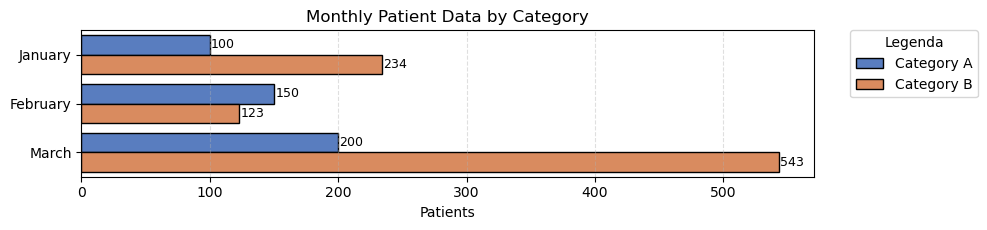

<Figure size 640x480 with 0 Axes>

In [6]:
# Input data
data = [
    [100, 150, 200],  # Category A values over months
    [234, 123, 543] # Category C values over months
]
months = ["January", "February", "March"]  # List of months
categories = ["Category A", "Category B"]  # List of categories

# Call the function
plot_monthly_data_sns(
    data=data,
    months=months,
    categories=categories,
    x_label="Patients",
    title="Monthly Patient Data by Category",
    save_path=None,  # Set to a file path if you want to save the plot
    width_to_add=1,
    integer=True
)


In [7]:
import ast

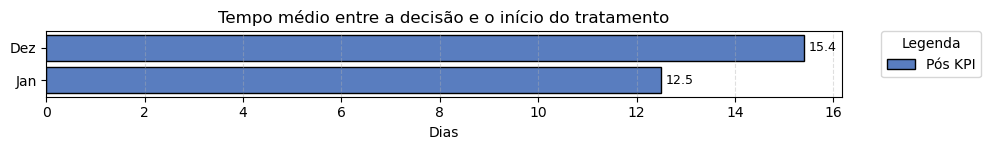

<Figure size 640x480 with 0 Axes>

In [32]:
# Input data
data = [
    [value[0] for value in agreggated_csv["a_postKPI"].apply(ast.literal_eval)],  # Category A values over months
]
months = ["Dez", "Jan"]  # List of months
categories = ["Pós KPI"]  # List of categories

# Call the function
plot_monthly_data_sns(
    data=data,
    months=months,
    categories=categories,
    x_label="Dias",
    title="Tempo médio entre a decisão e o início do tratamento",
    save_path=None,  # Set to a file path if you want to save the plot
    width_to_add=0.1
)

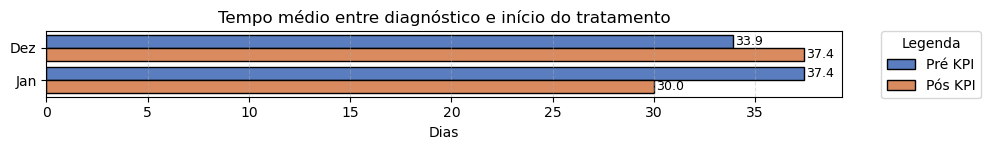

<Figure size 640x480 with 0 Axes>

In [33]:
# Input data
data = [
    [value[0] for value in agreggated_csv["b_preKPI"].apply(ast.literal_eval)],  # Category A values over months
    [value[0] for value in agreggated_csv["b_postKPI"].apply(ast.literal_eval)],  # Category A values over months
]
months = ["Dez", "Jan"]  # List of months
categories = ["Pré KPI", "Pós KPI"]  # List of categories

# Call the function
plot_monthly_data_sns(
    data=data,
    months=months,
    categories=categories,
    x_label="Dias",
    title="Tempo médio entre diagnóstico e início do tratamento",
    save_path=None,  # Set to a file path if you want to save the plot
    width_to_add=0.1
)

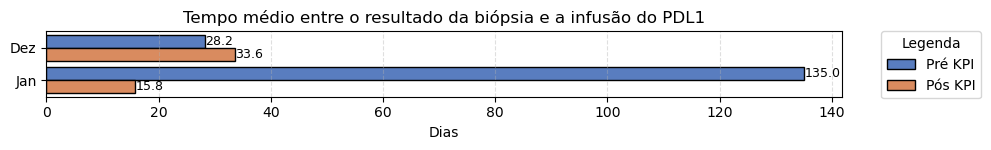

<Figure size 640x480 with 0 Axes>

In [34]:
# Input data
data = [
    [value[0] for value in agreggated_csv["c_preKPI"].apply(ast.literal_eval)],  # Category A values over months
    [value[0] for value in agreggated_csv["c_postKPI"].apply(ast.literal_eval)],  # Category A values over months
]
months = ["Dez", "Jan"]  # List of months
categories = ["Pré KPI", "Pós KPI"]  # List of categories

# Call the function
plot_monthly_data_sns(
    data=data,
    months=months,
    categories=categories,
    x_label="Dias",
    title="Tempo médio entre o resultado da biópsia e a infusão do PDL1",
    save_path=None,  # Set to a file path if you want to save the plot teste
    width_to_add=0.1
)

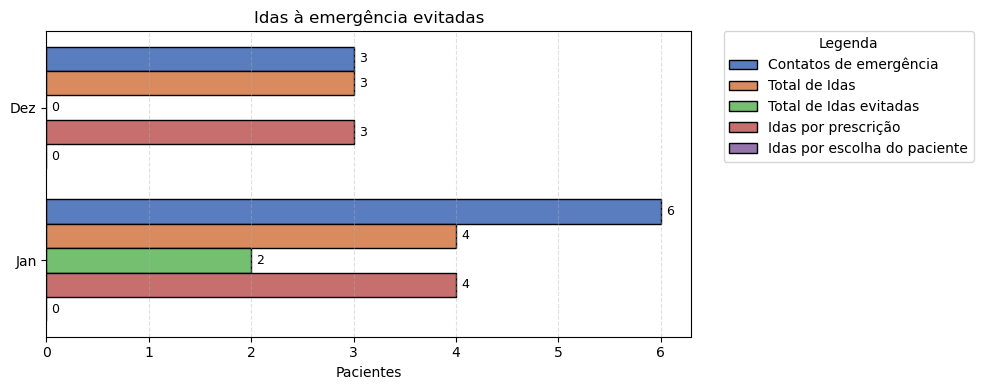

<Figure size 640x480 with 0 Axes>

In [35]:
# Total de Contatos de emergência
# Total de Idas
# Total de Idas evitadas
# Idas por prescrição
# Idas por escolha do paciente

# Input data
data = [
    [value[0][0] for value in agreggated_csv["d"].apply(ast.literal_eval)],  # Category A values over months
    [value[0][2] for value in agreggated_csv["d"].apply(ast.literal_eval)],
    [value[0][1] for value in agreggated_csv["d"].apply(ast.literal_eval)],
    [value[0][3] for value in agreggated_csv["d"].apply(ast.literal_eval)],
    [value[0][4] for value in agreggated_csv["d"].apply(ast.literal_eval)]
]
months = ["Dez", "Jan"]  # List of months
categories = [
    "Contatos de emergência", 
    "Total de Idas",
    "Total de Idas evitadas",
    "Idas por prescrição",
    "Idas por escolha do paciente"
    ]  # List of categories
    
# Call the function
plot_monthly_data_sns(
    data=data,
    months=months,
    categories=categories,
    x_label="Pacientes",
    title="Idas à emergência evitadas",
    save_path=None,  # Set to a file path if you want to save the plot
    width_to_add=0.05,
    height=2,
    integer=True
)
# Botar os zeros nas barras que não tem valor

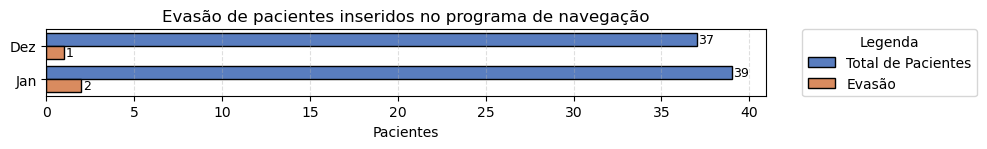

<Figure size 640x480 with 0 Axes>

In [40]:
# Total de Contatos de emergência
# Total de Idas
# Total de Idas evitadas
# Idas por prescrição
# Idas por escolha do paciente

# Input data
data = [
    [value[0][1] for value in agreggated_csv["f"].apply(ast.literal_eval)],  # Category A values over months
    [value[0][0] for value in agreggated_csv["f"].apply(ast.literal_eval)]
]
months = ["Dez", "Jan"]  # List of months
categories = [
    "Total de Pacientes", 
    "Evasão"
    ]  # List of categories

# Call the function
plot_monthly_data_sns(
    data=data,
    months=months,
    categories=categories,
    x_label="Pacientes",
    title="Evasão de pacientes inseridos no programa de navegação",
    save_path=None,  # Set to a file path if you want to save the plot
    width_to_add=0.1,
    integer=True
)

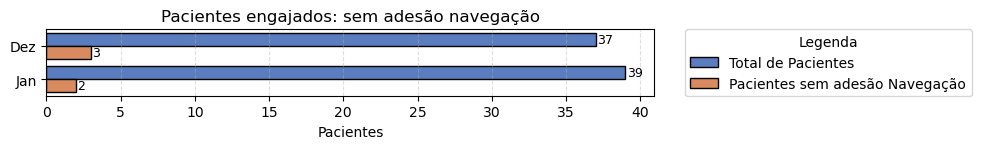

<Figure size 640x480 with 0 Axes>

In [37]:
# Total de Contatos de emergência
# Total de Idas
# Total de Idas evitadas
# Idas por prescrição
# Idas por escolha do paciente

# Input data
data = [
    [value[0][1] for value in agreggated_csv["g_nao_navegacao"].apply(ast.literal_eval)],  # Category A values over months
    [value[0][0] for value in agreggated_csv["g_nao_navegacao"].apply(ast.literal_eval)]
]
months = ["Dez", "Jan"]  # List of months
categories = [
    "Total de Pacientes", 
    "Pacientes sem adesão Navegação"
    ]  # List of categories

# Call the function
plot_monthly_data_sns(
    data=data,
    months=months,
    categories=categories,
    x_label="Pacientes",
    title="Pacientes engajados: sem adesão navegação",
    save_path=None,  # Set to a file path if you want to save the plot
    width_to_add=0.1,
    integer=True
)

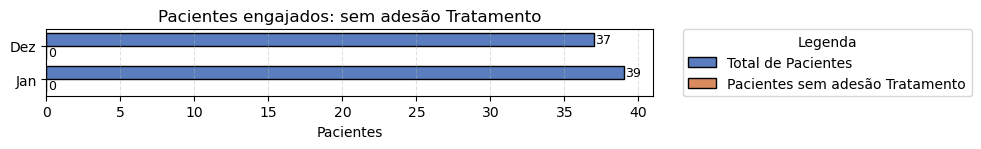

<Figure size 640x480 with 0 Axes>

In [39]:
# Total de Contatos de emergência
# Total de Idas
# Total de Idas evitadas
# Idas por prescrição
# Idas por escolha do paciente

# Input data
data = [
    [value[0][1] for value in agreggated_csv["g_nao_tto"].apply(ast.literal_eval)],  # Category A values over months
    [value[0][0] for value in agreggated_csv["g_nao_tto"].apply(ast.literal_eval)]
]
months = ["Dez", "Jan"]  # List of months
categories = [
    "Total de Pacientes", 
    "Pacientes sem adesão Tratamento"
    ]  # List of categories

# Call the function
plot_monthly_data_sns(
    data=data,
    months=months,
    categories=categories,
    x_label="Pacientes",
    title="Pacientes engajados: sem adesão Tratamento",
    save_path=None,  # Set to a file path if you want to save the plot
    width_to_add=0.1,
    integer=True
)